<a href="https://colab.research.google.com/github/MingSheng92/AE_denoise/blob/master/DL_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: google-pasta, termcolor, protobuf, absl-py, tensorflow-estimator, grpcio, wrapt, six, keras-preprocessing, opt-einsum, gast, tensorboard, numpy, keras-applications, astor, wheel
Required-by: stable-baselines, magenta, fancyimpute


In [2]:
!git clone https://github.com/MingSheng92/AE_denoise.git

Cloning into 'AE_denoise'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 48 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%load /content/AE_denoise/scripts/utility.py
%load /content/AE_denoise/scripts/Denoise_NN.py

from AE_denoise.scripts.utility import load_data, faceGrid, ResultGrid, subsample, AddNoiseToMatrix, noisy
from AE_denoise.scripts.Denoise_NN import PSNRLoss, createModel

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
img_data, label, img_size = load_data('/content/drive/My Drive/FaceDataset/CroppedYaleB', 0)
#img_data, label, img_size = load_data('/content/drive/My Drive/FaceDataset/ORL', 0)

In [36]:
img_size

(168, 168)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(img_data.T, label, test_size=0.1, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=111)

print("Total number of training samples: ", x_train.shape)
print("Total number of training samples: ", x_val.shape)
print("Total number of validation samples: ", x_test.shape)

Total number of training samples:  (1962, 28224)
Total number of training samples:  (218, 28224)
Total number of validation samples:  (243, 28224)


In [0]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#x_train = x_train.reshape(-1, img_size[0], img_size[1], 1)
#x_val = x_val.reshape(-1, img_size[0], img_size[1], 1)
x_train = np.reshape(x_train, (len(x_train), img_size[0], img_size[1], 1))
x_val = np.reshape(x_val, (len(x_val), img_size[0], img_size[1], 1))
x_test = np.reshape(x_test, (len(x_test), img_size[0], img_size[1], 1)) 

In [0]:
# add noise to the face images
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

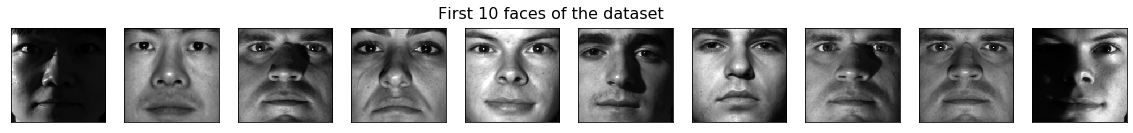

In [70]:
faceGrid(10, x_train, img_size, 64)

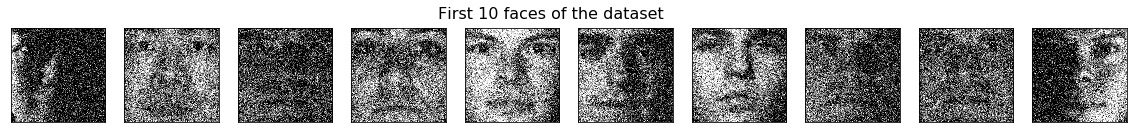

In [71]:
faceGrid(10, x_train_noisy, img_size, 64)

In [0]:
model = createModel(img_size)

In [131]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 168, 168, 1)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 168, 168, 64)      1664      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 168, 168, 64)      102464    
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 168, 168, 64)      102464    
_________________________________________________________________
dropout_5 (Dropout)          (None, 168, 168, 64)      0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 168, 168, 64)      256       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 168, 168, 32)      184

In [132]:
model.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=64,
                validation_data=(x_val_noisy, x_val))

Train on 1962 samples, validate on 218 samples
Epoch 1/15
1962/1962 [==============================] - 23s 12ms/step - loss: 0.0238 - PSNRLoss: 17.4902 - val_loss: 0.0526 - val_PSNRLoss: 12.7983
Epoch 2/15
1962/1962 [==============================] - 19s 10ms/step - loss: 0.0066 - PSNRLoss: 21.8847 - val_loss: 0.0737 - val_PSNRLoss: 11.3278
Epoch 3/15
1962/1962 [==============================] - 19s 10ms/step - loss: 0.0050 - PSNRLoss: 23.0366 - val_loss: 0.0123 - val_PSNRLoss: 19.0879
Epoch 4/15
1962/1962 [==============================] - 19s 10ms/step - loss: 0.0043 - PSNRLoss: 23.7915 - val_loss: 0.0052 - val_PSNRLoss: 22.8809
Epoch 5/15
1962/1962 [==============================] - 19s 10ms/step - loss: 0.0038 - PSNRLoss: 24.3160 - val_loss: 0.0054 - val_PSNRLoss: 22.6885
Epoch 6/15
1962/1962 [==============================] - 19s 10ms/step - loss: 0.0040 - PSNRLoss: 24.0530 - val_loss: 0.0253 - val_PSNRLoss: 15.9726
Epoch 7/15
1962/1962 [==============================] - 19s 10ms/

In [0]:
denoise_prediction = model.predict(x_test_noisy)

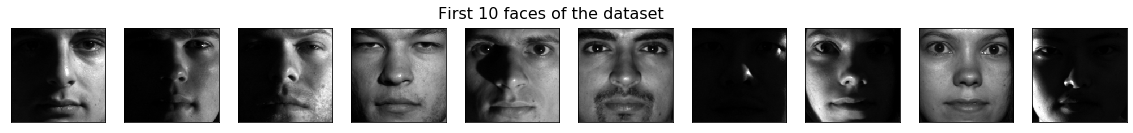

In [116]:
faceGrid(10, x_test, img_size, 5)

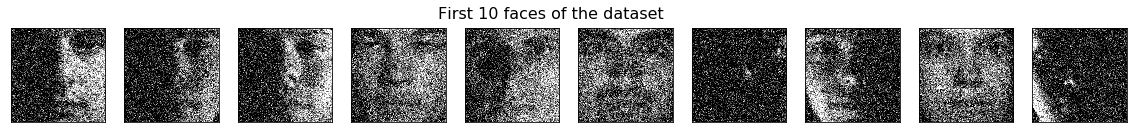

In [105]:
faceGrid(10, x_test_noisy, img_size, 5)

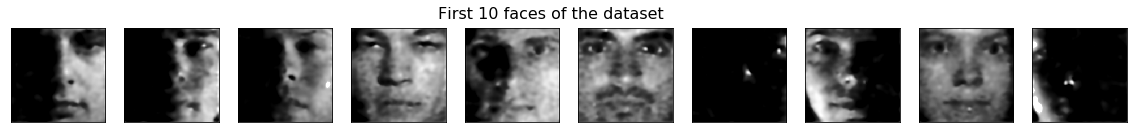

In [134]:
faceGrid(10, denoise_prediction, img_size, 5)